In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import widgets
import os
from PIL import Image
import pickle
from io import BytesIO

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
!pipreqs "/content/drive/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
INFO: Not scanning for jupyter notebooks.


In [7]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

In [ ]:
# LOAD THE DATASETS

TRAIN_DIR = '/content/drive/Shareddrives/Project Capstone Temporary/Datasets/expressionData/images/train'
VAL_DIR = '/content/drive/Shareddrives/Project Capstone Temporary/Datasets/expressionData/images/test'

train_nostress_dir = os.path.join(TRAIN_DIR, 'active')
train_stress_dir = os.path.join(TRAIN_DIR, 'fatigue')

val_nostress_dir = os.path.join(VAL_DIR, 'active')
val_stress_dir = os.path.join(VAL_DIR, 'fatigue')

sample_image = Image.open(os.path.join(train_nostress_dir, os.listdir(train_nostress_dir)[0]))

print(f"There are {len(os.listdir(train_stress_dir)) + len(os.listdir(train_nostress_dir))} total of training images.")
print("")
print(f"There are {len(os.listdir(train_stress_dir))} training images of stressed face.")
print(f"There are {len(os.listdir(train_nostress_dir))} training images of no stressed face.")
print("")
print(f"There are {len(os.listdir(val_stress_dir))} validation images of stressed face.")
print(f"There are {len(os.listdir(val_nostress_dir))} validation images of no stressed face.")
print("")
print("Sample image size (width, height):", sample_image.size)
print("Number of color channels:", len(sample_image.getbands()))

There are 12105 total of training images.

There are 4931 training images of stressed face.
There are 7174 training images of no stressed face.

There are 1139 validation images of stressed face.
There are 1825 validation images of no stressed face.

Sample image size (width, height): (48, 48)
Number of color channels: 1


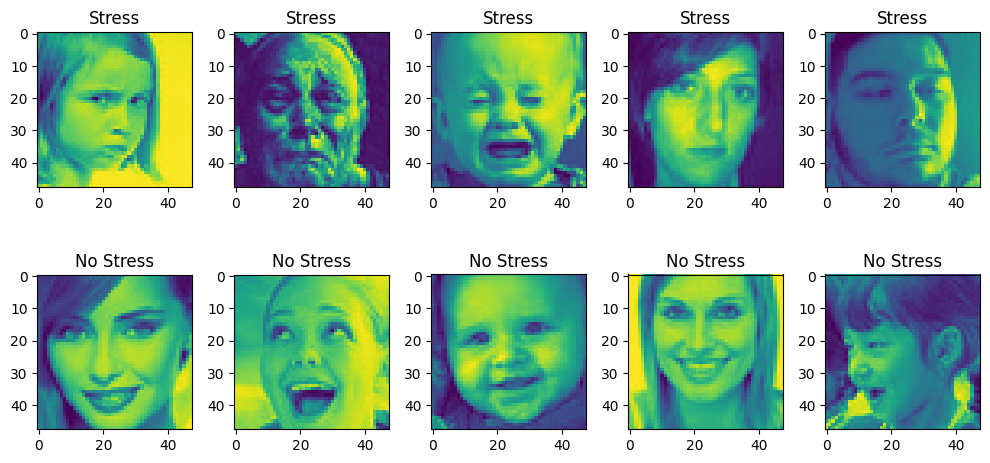

In [ ]:
#Seeing the first stress and no stress image from train_dir

train_stress_fnames = os.listdir(train_stress_dir)
train_nostress_fnames = os.listdir(train_nostress_dir)

plt.figure(figsize=(10, 5))

for i, fname in enumerate(train_stress_fnames[:5]):
    img_path = os.path.join(train_stress_dir, fname)
    img = mpimg.imread(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title("Stress")


# Viewing the images
for i, fname in enumerate(train_nostress_fnames[:5]):
    img_path = os.path.join(train_nostress_dir, fname)
    img = mpimg.imread(img_path)
    plt.subplot(2, 5, i + 6)
    plt.imshow(img)
    plt.title("No Stress")


plt.tight_layout()
plt.show()

In [ ]:
#LOAD TRAINING AND VALIDATION DATASET


def load_training_validation_dataset():
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        image_size=(48, 48),
        batch_size=BATCH_SIZE,
        shuffle=True,
        color_mode='grayscale'
    )

    val_dataset = tf.keras.utils.image_dataset_from_directory(
        VAL_DIR,
        image_size=(48, 48),
        batch_size=BATCH_SIZE,
        shuffle=False,
        color_mode='grayscale'
    )

    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, val_dataset

In [ ]:
training_dataset, validation_dataset = load_training_validation_dataset()

Found 12105 files belonging to 2 classes.
Found 2964 files belonging to 2 classes.


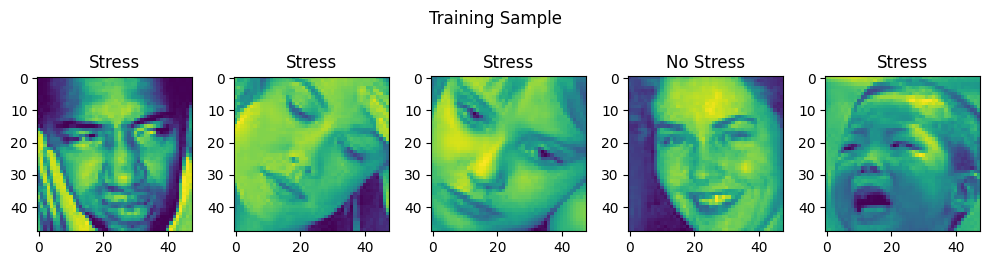

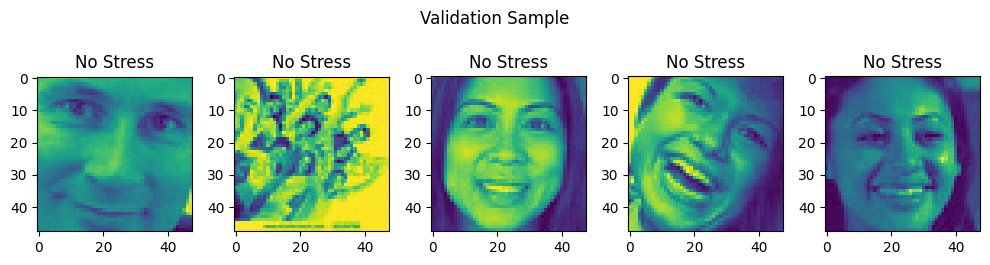

Maximum pixel value of images: 255.0

Shape of batch of images: (64, 48, 48, 1)
Shape of batch of labels: (64,)


In [ ]:
for images, labels in training_dataset.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Stress" if labels[i] == 1 else "No Stress")
        plt.axis=("off")
    plt.suptitle("Training Sample")
    plt.tight_layout()
    plt.show()

for images, labels in validation_dataset.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Stress" if labels[i] == 1 else "No Stress")
        plt.axis=("off")
    plt.suptitle("Validation Sample")
    plt.tight_layout()
    plt.show()


for images, labels in training_dataset.take(1):
    example_batch_images = images
    example_batch_labels = labels


print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")


In [ ]:
# INISIALISASI CALLBACK

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
training_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

val_gen = ImageDataGenerator(    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

In [ ]:
training_set = training_gen.flow_from_directory(TRAIN_DIR, target_size=(48,48),batch_size=BATCH_SIZE,class_mode='binary', shuffle=True,color_mode='grayscale')
validation_set = val_gen.flow_from_directory(VAL_DIR, target_size=(48,48),batch_size=BATCH_SIZE,class_mode='binary', shuffle=True,color_mode='grayscale')

Found 12105 images belonging to 2 classes.
Found 2964 images belonging to 2 classes.


In [ ]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(48,48,1)),

        # Feature extraction layer 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),

        #Feature extraction layer 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(0.2),

        # Feature extraction layer 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        # Feature extraction layer 4
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [ ]:
# TRAINING THE MODEL

training_history = model.fit(
    x=training_set,
    validation_data=validation_set,
    epochs=30,
    verbose=1,
    callbacks=[reduce_lr]
)

Epoch 1/30
190/190 [==============================] - 2306s 11s/step - loss: 5.0346 - accuracy: 0.5879 - val_loss: 6.8467 - val_accuracy: 0.3843 - lr: 1.0000e-04
Epoch 2/30
190/190 [==============================] - 60s 315ms/step - loss: 3.5204 - accuracy: 0.6086 - val_loss: 3.1086 - val_accuracy: 0.6134 - lr: 1.0000e-04
Epoch 3/30
190/190 [==============================] - 60s 315ms/step - loss: 2.5583 - accuracy: 0.6176 - val_loss: 2.3751 - val_accuracy: 0.6309 - lr: 1.0000e-04
Epoch 4/30
190/190 [==============================] - 60s 316ms/step - loss: 1.9210 - accuracy: 0.6169 - val_loss: 1.6783 - val_accuracy: 0.6265 - lr: 1.0000e-04
Epoch 5/30
190/190 [==============================] - 60s 315ms/step - loss: 1.4939 - accuracy: 0.6221 - val_loss: 1.3289 - val_accuracy: 0.6383 - lr: 1.0000e-04
Epoch 6/30
190/190 [==============================] - 59s 312ms/step - loss: 1.2024 - accuracy: 0.6406 - val_loss: 1.1016 - val_accuracy: 0.6404 - lr: 1.0000e-04
Epoch 7/30
190/190 [========

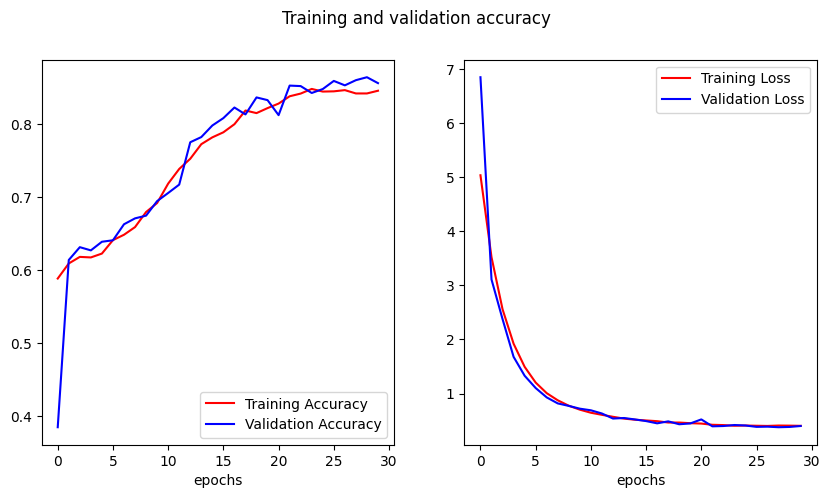

In [ ]:
# Get training and validation accuracies
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [ ]:
model_save_path = '/content/drive/Shareddrives/Project Capstone Temporary/Trained Model/Model_StressDetection_V6.h5'
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Create the widget and take care of the display

uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

rescale_layer = tf.keras.layers.Rescaling(scale=1./255)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(48, 48), color_mode='grayscale')
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)

    prediction = new_model.predict(image, verbose=0)[0][0]
    print(prediction)

    stress_percent  = prediction * 100
    no_stress_percent = (1 - prediction) * 100  # Persentase no stress (1 - prediction)
    # stress_percent = prediction * 100

    # Display the result
    with out:
        print(f"Prediction for {filename}:")
        print(f"No Stress: {no_stress_percent:.2f}%")
        print(f"Stress: {stress_percent:.2f}%")

        if prediction > 0.5:
            print(f"{filename} is classified as Stressed")
        else:
            print(f"{filename} is classified as No Stress")

def on_upload_change(change):
    items = change.new
    print(items)
    for filename, file_data in items.items():  # Iterate over the uploaded files
            file_content = file_data['content']  # Get the binary content of the file
            file_jpgdata = BytesIO(file_content)  # Convert binary data to BytesIO
            file_predict(filename, file_jpgdata, out)

uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

{'01 nostress.jpg': {'metadata': {'name': '01 nostress.jpg', 'type': 'image/jpeg', 'size': 47380, 'lastModified': 1732212795550}, 'content': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\x06\x06\x06\x06\x07\x06\x07\x08\x08\x07\n\x0b\n\x0b\n\x0f\x0e\x0c\x0c\x0e\x0f\x16\x10\x11\x10\x11\x10\x16"\x15\x19\x15\x15\x19\x15"\x1e$\x1e\x1c\x1e$\x1e6*&&*6>424>LDDL_Z_||\xa7\x01\x06\x06\x06\x06\x07\x06\x07\x08\x08\x07\n\x0b\n\x0b\n\x0f\x0e\x0c\x0c\x0e\x0f\x16\x10\x11\x10\x11\x10\x16"\x15\x19\x15\x15\x19\x15"\x1e$\x1e\x1c\x1e$\x1e6*&&*6>424>LDDL_Z_||\xa7\xff\xc2\x00\x11\x08\x05\x00\x02\xd1\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00/\x00\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x02\xfdP\x00\x00\x00\x00\x00\x00\x00\x96P\x04\xa8\x80\x04\x01(\xe7:E\xe5\x8e\xf98\xb7"k6\x

In [ ]:
new_model_save_path = '/content/drive/Shareddrives/Project Capstone Temporary/Trained Model/Model_StressDetection_V5_Lebih_ke_Stress.keras'
new_model.save(model_save_path)

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/Shareddrives/Project Capstone Temporary/Trained Model/Model_StressDetection_V6.keras')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [ ]:
save_json_path = '/content/drive/Shareddrives/Project Capstone Temporary/Trained Model/Model_StressDetection_V6.json'

model_json = loaded_model.to_json()

# Simpan model JSON ke file
with open(save_json_path, 'w') as json_file:
    json_file.write(model_json)


In [ ]:
with open(save_json_path, 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7